In [2]:
import os
import torch
import random
import pickle
# import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


## tldr

Dataset unpickles files from folder and returns images & labels. 
- If mode == train, applies SimCLR augmentations (using Albumentations) and returns 2 augmented images + label
- Ig mode ==test, resizes, crops, and normalizes image, which it returns with label. 

All augmentations should perform similar to pytorch transforms used except a noted issue in Albumentations where resizing uses cv2.inter_linear interpolation whereas torch uses bilinear cv2.interpolation. People find lower performance with albumentations. 

Q: Not sure if RandomResize is always applied (?)

Q: Some confusion how Gaussian Blur works, so not sure if the SimCLR defined function vs Albumentations does similar things but looks similar enough. 

Q: the WCL dataset has a default augmentation pipeline, which is different from eval_aug (which is presumably used for testing mode only). Not sure what the default is but this implementation uses eval_aug transforms for test data and simclr augmentations for train data. They warm up with moco_aug, but I have notv used that here. 

**Note** A better way would've been just to have a dataset that returns image and label (works for both train and test), and have two data loaders for training data (x1, x2) with the simclr transforms and one data loader for test data with evaluation augmentations. 

## Code

### Transforms

In [3]:
os.getcwd()
os.chdir('/home/sshad/data/wcl-data')

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

examples = unpickle('val_images')

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
import albumentations as A

In [174]:
examples[5].shape

(3072,)

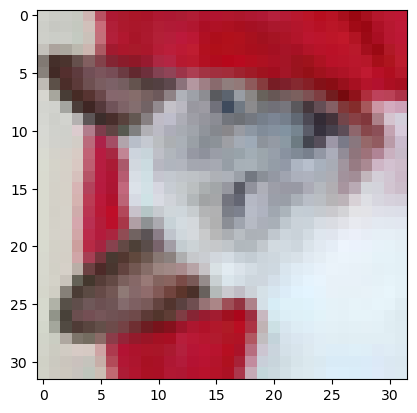

In [86]:
ex = examples[5053].reshape(3, 32, 32)
ext = torch.from_numpy(ex.transpose()) #plt.imshow requires (W H 3)
plt.imshow(ext)

##### RandomResizedCrop

Questions: 
- is it always applied in the pytorch implementation?

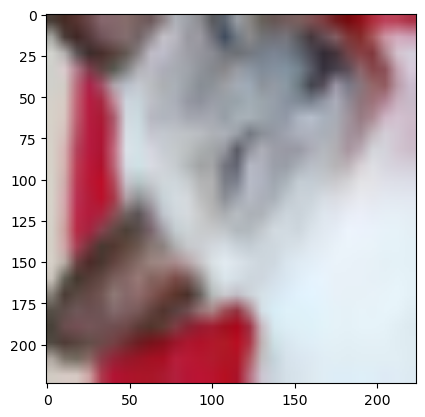

In [93]:
# Pytorch 

transform = transforms.RandomResizedCrop(224) 
input = torch.transpose(ext, 0, 2) #transforms requires [3 H W]
out = transform(input)
img = torch.transpose(out, 0, 2) # for plt
plt.imshow(img)

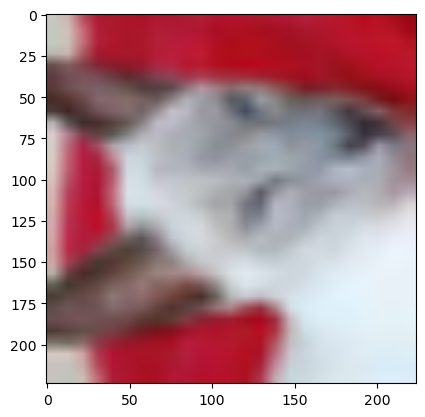

In [102]:
# Albumentations

albumen = A.RandomResizedCrop(height=224, width=224)
input = ex.transpose() # albumentations requires numpy input 
output = albumen(image =input)['image']
plt.imshow(output)

Looks different (but might be ok!). [One issue is listed here](https://discuss.pytorch.org/t/replacing-torchivision-with-albumentations-transforms-is-lowering-performance/166987) but I do not know why that would create such different crops... 


**Did not check the rest**

##### Gaussian Blur

For the Gaussian Blur, this is mentioned in the [SimCLR] publication mentioned in WCL code. 

We blur the image 50% of the time using a Gaussian kernel. We randomly sample σ ∈ [0.1, 2.0], and the *kernel size is set to be 10% of the image height/width*. 

A.GaussianBlur requires MAX kernel size, so it might be ok? 

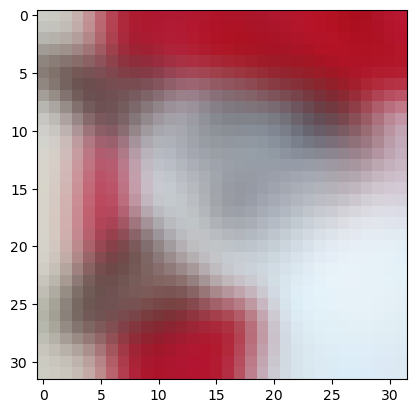

In [112]:
# Pytorch 

from PIL import ImageFilter, Image, ImageOps

class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([GaussianBlur([.1, 2.])], p=1),
    transforms.ToTensor()])
input = torch.transpose(ext, 0, 2) #transforms requires [3 H W]
out = transform(input)
img = torch.transpose(out, 0, 2) # for plt
plt.imshow(img)

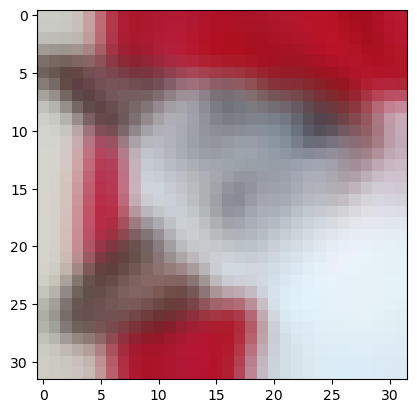

In [121]:
# Albumentations

albumen = A.GaussianBlur(sigma_limit=(0.1, 2.0), p=1)
input = ex.transpose() # albumentations requires numpy input 
output = albumen(image =input)['image']
plt.imshow(output)

##### All Transforms

In [144]:
# Pytorch - to recreate
simclr_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToPILImage(), ## added this
    transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = A.Compose([
    A.RandomResizedCrop(height=224, width=224),
    A.HorizontalFlip(),
    A.ColorJitter(p=0.8, brightness=0.8, 
                  contrast=0.8, saturation=0.8, hue=0.2),
    A.ToGray(p=0.2),
    A.GaussianBlur(sigma_limit=(0.1, 2.0)),
    A.Normalize()
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


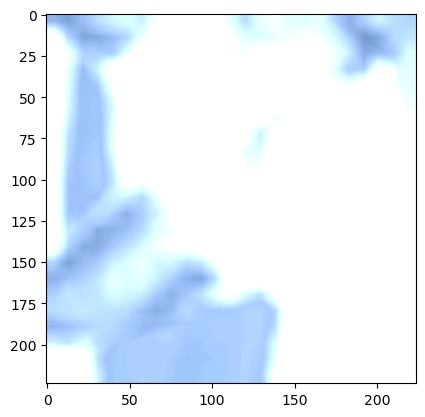

In [146]:
# Pytorch 
input = torch.transpose(ext, 0, 2) #transforms requires [3 H W]
out = simclr_aug(input)
img = torch.transpose(out, 0, 2) # for plt
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


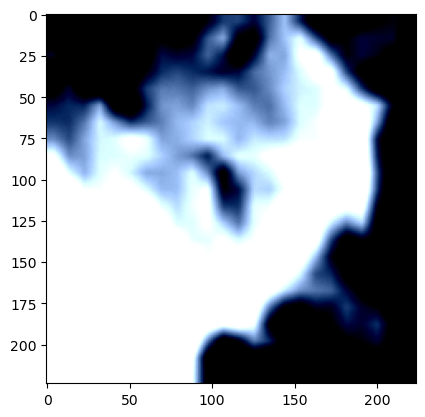

In [214]:
# Albumentations

input = ex.transpose() # albumentations requires numpy input 
output = transform(image =input)['image']
plt.imshow(output)

Ran a few times, similar results.. 

### Dataset

Question: 
- [eval_aug](/home/sshad/WCL/data/augmentation.py) is different from [transforms when none are provided](/home/sshad/WCL/data/imagenet.py). Which one should I use 
> Currently using eval_aug
- Where are they called? 

In [22]:

# import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')

# import os
class TrialContrastiveCIFAR10(Dataset): 

    def __init__(self, mode='train'): 
        """ accepts mode train, val, or test"""
        super().__init__()
        self.mode = mode
        
        # unpickle data
        os.chdir('/home/sshad/data/wcl-data')
        self.images = unpickle(f'{self.mode}_images')

        # might not need this for pre-training
        self.labels = unpickle(f'{self.mode}_labels') 

        ## SimCLR transformations
        if mode == 'train': 
            self.transform = A.Compose([
            A.RandomResizedCrop(height=224, width=224),
            A.HorizontalFlip(),
            A.ColorJitter(p=0.8, brightness=0.8, 
                        contrast=0.8, saturation=0.8, hue=0.2),
            A.ToGray(p=0.2),
            A.GaussianBlur(sigma_limit=(0.1, 2.0)),
            A.Normalize()
            ])
        else: 
            self.transform = A.Compose([
                A.Resize(height=256, width=256), 
                A.CenterCrop(height=224, width=224), 
                A.Normalize()
            ])

    def __len__(self): 
        return len(self.images)
    
    def __getitem__(self, index): 
        image, label = self.images[index], self.labels[index]
        image = image.reshape(3, 32, 32).transpose() # transpose for aug
        if self.mode=='train': 
            img1 = self.transform(image=image)['image']
            img2 = self.transform(image=image)['image']
            return image, img1, img2, label # for testing the function only
            # return img1, img2, label
        return image, label

##### Testing with batch_size = 1

In [23]:
data = TrialContrastiveCIFAR10()
dl = DataLoader(data, batch_size=1)

In [26]:
og, outputa, outputb, _ = next(iter(dl))
print(outputa.shape)
outputa = outputa.squeeze()
outputb = outputb.squeeze()
og = og.squeeze() # for testing only
print(outputa.shape)

torch.Size([1, 224, 224, 3])
torch.Size([224, 224, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


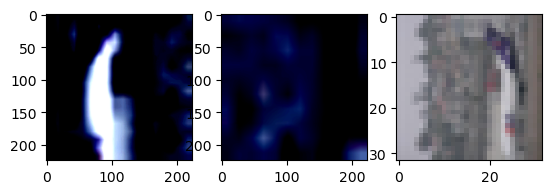

In [27]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(outputa)
ax[1].imshow(outputb)
ax[2].imshow(og) # for testing only
plt.show()

Sometimes spits out fully black images, but otherwise works? maybe? 

## Actual Model

In [ ]:

# import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')

# import os
class ContrastiveCIFAR10(Dataset): 

    def __init__(self, mode='train'): 
        """ accepts mode train, val, or test"""
        super().__init__()
        self.mode = mode
        
        # unpickle data
        os.chdir('/home/sshad/data/wcl-data')
        self.images = unpickle(f'{self.mode}_images')

        # might not need this for pre-training
        self.labels = unpickle(f'{self.mode}_labels') 

        ## SimCLR transformations
        if mode == 'train': 
            self.transform = A.Compose([
            A.RandomResizedCrop(height=28, width=28), #28 * 28 (no resize) [previously 224 * 224]
            A.HorizontalFlip(),
            # A.ColorJitter(p=0.8, brightness=0.8, 
                        # contrast=0.8, saturation=0.8, hue=0.2),
            # A.ToGray(p=0.2),
            # A.GaussianBlur(sigma_limit=(0.1, 2.0)),
            A.Normalize()
            ])
        else: 
            self.transform = A.Compose([ 
                A.CenterCrop(height=28, width=28), # 28 * 28 from 224 * 224
                A.Normalize()
            ])

    def __len__(self): 
        return len(self.images)
    
    def __getitem__(self, index): 
        
        image, label = self.images[index], self.labels[index]
        image = image.reshape(3, 32, 32).transpose() #transpose for augmentation
        if self.mode !='test': 
            img1 = self.transform(image=image)['image'].transpose()
            img2 = self.transform(image=image)['image'].transpose()
            return img1, img2, label
        image = self.transform(image=image)['image'].transpose()
        return image, label